# Trabalho Final de Computacional

**Bibliotecas necessárias para este trabalho:**

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from random import random
from numpy import zeros, copy, sqrt
import sys

# Problema 1 - Energia cinética e potencial de interação

Não foi preciso modificar o bloco abaixo, então mantemos a mesma estrutura.

In [6]:
# Define arquivo de saida
saida = open('MD.xyz','w')


# Função que escreve a trajetória, que deve ser lida usando o programa VMD
def dump():
    saida.write('{0:d} \n'.format(N))
    saida.write('\n')
    for i in range(N):
        saida.write( '1 {0:.3f} {1:.3f} 0.000 \n'.format( x[i], y[i]) )

# Função que calcula a força entre duas partículas. O primeiro 'if' implementa o raio de cut-off. O 'if' dentro do 'else' é útil em casos onde na configuração inicial existem átomos muito próximos, e evita que átomos saiam da caixa. Recomendo remover este segundo if após ter certeza que a configuração a ser usada é estável.
def f(r):
    if r>rcut:
        return 0.0
    else:
        f = 24.0*eps*( 2.0*(1/r)**(13) -  (1.0/r)**(7))
        if (f<100000):
            return f
        else:
            return 100000.0

# Define as posições iniciais
def init_pos():
    for i in range(N):
        x[i] = L/(Nx) * (i % (Nx)) + random()*rfac*(L/Nx) 
        divy = N/Ny
        y[i] = L/Ny * int((i / divy)) + random()*rfac*(L/Ny) 

# Define as velocidades iniciais
def init_vel():
    for i in range(N):
         vx[i] = 2.0*v0*(random()-0.5)
         vy[i] = 2.0*v0*(random()-0.5)

# Inicializa as posições e velocidades anteriores
def init_prev():
    for i in range(N):
         xprev[i] = x[i]-vx[i]*dt
         yprev[i] = y[i]-vy[i]*dt

# Programa que determina a força resultante sobre cada átomo
def calcforces():
    for j in range(N):
        if (j!=i):
            xji = x[j]-x[i]
            yji = y[j]-y[i]
            
            if (xji>0.5*L):
                xji = xji - L
            elif (xji <-0.5*L):
                xji = xji + L
                
            if (yji>0.5*L):
                yji = yji - L
            elif (yji <-0.5*L):
                yji = yji + L
                
            rji = sqrt (xji**2 + yji**2)
            fji = f(rji)
            coseno = -xji/rji
            seno = -yji/rji
            fx[i]+= fji*coseno
            fy[i]+= fji*seno

**Modificações feitas no código:**

*   Criamos a função **FU()** que calcula a soma das energias potenciais de cada partícula i com as outras j.

In [8]:
def fU(): # calculando a energia potencial
    U_part = 0
    for i in range(N):
        for j in range(i+1,N):
            if (j!=i):
                xji = x[j]-x[i]
                if (xji>0.5*L):
                    xji = xji - L
                elif (xji <-0.5*L):
                    xji = xji + L
                    
                yji = y[j]-y[i]
                if (yji>0.5*L):
                    yji = yji - L
                elif (yji <-0.5*L):
                    yji = yji + L
                rji = sqrt (xji**2 + yji**2)
                U_part += 4 * eps * ((sigma/rji)**12 - (sigma/rji)**6)
    return U_part



*   Abaixo, dentro do "while", nos passos de tempo dt, adicionamos os valores de energia cinética através das velocidades com "**T.append(sum(T_part))**".

*   Também adicionamos as energias potenciais retornadas pela função **FU(), com "U.append(U_total)**".

In [10]:
eps = 1.0
######################### Parâmetros da simulação ########################
# Número de átomos na simulação
N = 4
# Nx e Ny definem como será o arranjo 2D de átomos. N = Nx * Ny
Nx = 2
Ny = 2
# A velocidade inicial dos átomos é aleatória, e se situa no intervalo [-v0,v0]
v0 = 1.0
# A variável abaixo determina quão aleatória pode ser a posição inicial. Valores altos podem gerar configurações iniciais com átomos muito próximos. Valores entre 0 e 0.4 parecem funcionar bem.
rfac = 0.4
# A caixa é assumida quadrada, logo basta fornecer um valor de L
L = 10
# Passo da simulação (time-step)
dt = 0.005
# Número de passos
Npassos = 20000
# Raio de cut-off
rcut = 3.0
# O valor abaixo define o intervalo de tempo entre dois quadros da trajetória
tsave = 0.1
T = []
U = []
#U_part = np.zeros(N,float)
T_part = np.zeros(N,float)
m = 1  #6.7 x 10^{-26} kg
sigma = 1 #3.4 x 10^{-10}m
eps = 1 #1.65 x 10^[-21]J
#time = 4.5 x 10^{-12}s   raiz de (m sigma²/eps)
#temperature 119K   eps/kb
########################### Fim dos parâmetros  ##########################

if (Nx*Ny != N):
    print ("O arranjo escolhido de átomos não é consistente com o número total de átomos.")
    sys.exit()
    
x = np.zeros(N,float)
y = np.zeros(N,float)
vx = np.zeros(N,float)
vy = np.zeros(N,float)
xprev = np.zeros(N,float)
yprev = zeros(N,float)
xnew = np.zeros(N,float)
ynew = np.zeros(N, float)
fx = np.zeros(N,float)
fy = np.zeros(N,float)

init_pos()
init_vel()
init_prev()
    
dump()
t = 0
tol1 = 1.0e-6
tol2 = 1.0e-4

while (t < (Npassos*dt)):
    t+=dt
    for i in range(N):
        fx[i] = 0.0
        fy[i] = 0.0
        calcforces()
        
        xnew[i] = 2.0*x[i] - xprev[i] + fx[i]*dt**2
        if xnew[i]<0.0:
            xnew[i]+=L
            x[i]+=L 
            xprev[i]+=L
        elif xnew[i] > L:
            xnew[i]-=L
            x[i]-=L
            xprev[i]-=L

        ynew[i] = 2.0*y[i] - yprev[i] + fy[i]*dt**2
        if ynew[i]<0.0:
            ynew[i]+=+L
            y[i]+=L
            yprev[i]+=L
        elif ynew[i] > L:
            ynew[i]-=L
            y[i]-=L
            yprev[i]-=L

        vx[i] = (xnew[i]-xprev[i])/(2*dt)
        vy[i] = (ynew[i]-yprev[i])/(2*dt)

            
        v2 = vx[i]**2 + vy[i]**2
        T_part[i] = (m/2)*v2
        
    U_total = fU()
    U.append(U_total)
    T.append(sum(T_part))

    xprev = copy(x)
    yprev = copy(y)
    x = copy(xnew)
    y = copy(ynew)
    #dump()
    if ((t+tol1)%tsave < tol2):
        # print(t)
        dump()
      

saida.close()

In [11]:
print(len(T),len(U))

20001 20001


*   Assim, calculamos a energia total "**Etot[ i ] = T[ i ] + U[ i ]**" e plotamos as curvas das três energias.

In [13]:
T = np.array(T)
E = [T[i] + U[i] for i in range(len(T))]
time = np.linspace(0,100, len(T))

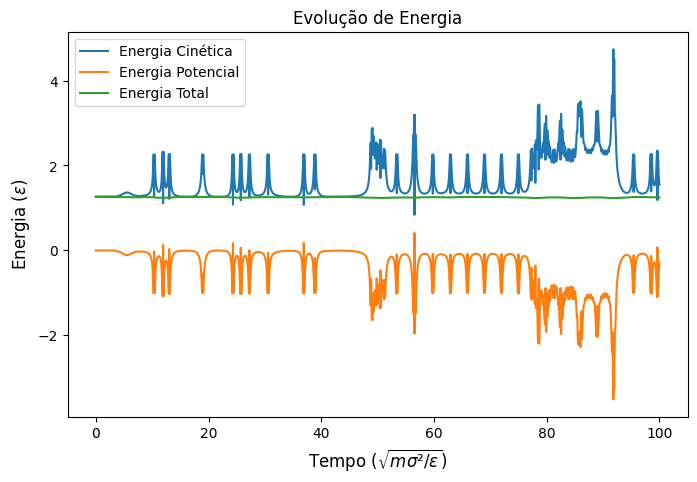

In [14]:
plt.figure(figsize=(8,5))
plt.title('Evolução de Energia')
plt.plot(time, T, label='Energia Cinética')
plt.plot(time, U, label='Energia Potencial')
plt.plot(time, E, label='Energia Total')
plt.xlabel(r'Tempo ($\sqrt{m \sigma²/\epsilon})$', fontsize = 12)
plt.ylabel(r'Energia ($\epsilon$)', fontsize = 12)
#plt.ylim(-3,3)
plt.legend()
plt.savefig('Q1')

# Problema 2 - Derretimento de sólido

**Modificações feitas no código:**

*   Modificamos as posições iniciais para formar a estrutura inicial triangular para as 22 particulas em "**def init_pos()**".

*   Também zeramos as velocidades iniciais para visualizar seu aumento no tempo, em "**def init_vel()**"

*   Em **calcforces()**, acrescentamos uma limitação para distâncias muito pequenas "**rji < 1e-10**", para não haver divergencias.

In [17]:
# Define arquivo de saida
saida = open('MD.xyz','w')

# Função que escreve a trajetória, que deve ser lida usando o programa VMD
def dump():
    saida.write('{0:d} \n'.format(N))
    saida.write('\n')
    for i in range(N):
        saida.write( '1 {0:.3f} {1:.3f} 0.000 \n'.format( x[i], y[i]) )

# Função que calcula a força entre duas partículas. O primeiro 'if' implementa o raio de cut-off. O 'if' dentro
# do 'else' é útil em casos onde na configuração inicial existem átomos muito próximos, e evita que átomos saiam 
# da caixa. Recomendo remover este segundo if após ter certeza que a configuração a ser usada é estável.
def f(r):
    if r>rcut:
        return 0.0
    else:
        f = 24.0*eps*( 2.0*(1/r)**(13) -  (1.0/r)**(7))
        if (f<1000):
            return f
        else:
            return 1000.0


# Queremos definir as posições iniciais em forma de cristal com as particulas equidistantes R ~ 1.20

def init_pos():
    for i in range(N):
        if i<3:                    # 0 1 2
            x[i] = L/5 + 1.2 + 1.2*i
            y[i] = L/2 - 2.08
        elif i<7:                  # 3 4 5 6
            x[i] = L/5 + 0.6 + 1.2*(i-3)
            y[i] = L/2 - 1.04
        elif i<12:                 # 7 8 9 10 11
            x[i] = L/5 + 1.2*(i-7)
            y[i] = L/2
        elif i<16:                 # 12 13 14 15
            x[i] = L/5 + 0.6 + 1.2*(i-12)
            y[i] = L/2 + 1.04
        else:                      # 16 17 18
            x[i] = L/5 + 1.2 + 1.2*(i-16)
            y[i] = L/2 + 2.08
            
    x[19], y[19] = 4, 7.2
    x[20], y[20] = 4, 0.64

# Define as velocidades iniciais
def init_vel():
    for i in range(N):
        # vx[i] = 2.0*v0*(random()-0.5)
        # vy[i] = 2.0*v0*(random()-0.5)
        
        vx[i] = 0
        vy[i] = 0

# Inicializa as posições e velocidades anteriores
def init_prev():
    for i in range(N):
         xprev[i] = x[i]-vx[i]*dt
         yprev[i] = y[i]-vy[i]*dt

# Programa que determina a força resultante sobre cada átomo
def calcforces():

    rji_tot = 0
    
    for j in range(N):
        if (j!=i):
            xji = x[j]-x[i]
            yji = y[j]-y[i]
            
            if (xji>0.5*L):
                xji = xji - L
            elif (xji <-0.5*L):
                xji = xji + L
                
            if (yji>0.5*L):
                yji = yji - L
            elif (yji <-0.5*L):
                yji = yji + L

            rji = sqrt(xji**2 + yji**2)
            
            if rji < 1e-10:  # Evita erros numéricos
                continue
            rji_tot += rji
            
            fji = f(rji)
            coseno = -xji/rji
            seno = -yji/rji

            fx[i]+= fji*coseno
            fy[i]+= fji*seno
            
    return rji_tot/(N-1)

def fU(): # calculando a energia potencial
    U_part = 0
    for i in range(N):
        for j in range(i+1,N):
            if (j!=i):
                xji = x[j]-x[i]
                if (xji>0.5*L):
                    xji = xji - L
                elif (xji <-0.5*L):
                    xji = xji + L
                    
                yji = y[j]-y[i]
                if (yji>0.5*L):
                    yji = yji - L
                elif (yji <-0.5*L):
                    yji = yji + L

                rji = np.sqrt(xji**2 + yji**2)
                U_part += 4 * eps * ((sigma/rji)**12 - (sigma/rji)**6)
    return U_part

*   Abaixo, colocamos o sistema com 22 particulas e mudamos o tamanho da caixa para 8.

*   Não sabemos bem o motivo, mas para **haver interações significativas** tivemos que colocar o **raio de cut-off (R ~ 1.21)** com valor próximo à **distancia entre as particulas (rji ~ 1.20)**.

*   Além disso, acrescentamos as mudanças na velocidade pelas posições anteriores **xprev e yprev**, como é sugerido no livro do Giordano (pg.289). Também reparamos que o sistema só evoluía de maneira interessante se fizessemos o mesmo com as posições atuais **x e y**.

*   As distâncias foram calculadas pela própria função **calcforces()**, através das médias do parâmetro **rji**, utilizando **rji_tot**. Sabemos que foram calculadas de maneira correta porque o comportamento do gráfico final sempre condiz com as movimentações das partículas pelo VMD.

In [19]:
eps = 1.0
######################### Parâmetros da simulação ########################
# Número de átomos na simulação
N = 21
# Nx e Ny definem como será o arranjo 2D de átomos. N = Nx * Ny
Nx = 4
Ny = 4
# A velocidade inicial dos átomos é aleatória, e se situa no intervalo [-v0,v0]
v0 = 1.0
# A variável abaixo determina quão aleatória pode ser a posição inicial. Valores altos podem gerar configurações iniciais com átomos muito próximos. Valores entre 0 e 0.4 parecem funcionar bem.
rfac = 0.4
# A caixa é assumida quadrada, logo basta fornecer um valor de L
L = 8
# Passo da simulação (time-step)
dt = 0.005
# Número de passos
Npassos = 20000
# Raio de cut-off
rcut = 1.3
# O valor abaixo define o intervalo de tempo entre dois quadros da trajetória
tsave = 0.2
T = []
U = []
#U_part = np.zeros(N,float)
T_part = np.zeros(N,float)
m = 1  #6.7 x 10^{-26} kg
sigma = 1 #3.4 x 10^{-10}m
eps = 1 #1.65 x 10^[-21]J
#time = 4.5 x 10^{-12}s   raiz de (m sigma²/eps)
#temperature 119K   eps/kb
########################### Fim dos parâmetros  ##########################

# if (Nx*Ny != N):
#     print ("O arranjo escolhido de átomos não é consistente com o número total de átomos.")
#     sys.exit()
    
x = np.zeros(N,float)
y = np.zeros(N,float)
vx = np.zeros(N,float)
vy = np.zeros(N,float)
xprev = np.zeros(N,float)
yprev = zeros(N,float)
xnew = np.zeros(N,float)
ynew = np.zeros(N, float)
fx = np.zeros(N,float)
fy = np.zeros(N,float)

init_pos()
init_vel()
init_prev()

dump()
t = 0
tol1 = 1.0e-6
tol2 = 1.0e-4

distances = []

while (t < (Npassos*dt)):
    
    t+=dt
    dist = 0
    
    for i in range(N):
        fx[i] = 0.0
        fy[i] = 0.0
        calcforces()
        dist += calcforces()

        xnew[i] = 2.0*x[i] - xprev[i] + fx[i]*dt**2
        if xnew[i]<0.0:
            xnew[i]+=L
            x[i]+=L 
            xprev[i]+=L
        elif xnew[i] > L:
            xnew[i]-=L
            x[i]-=L
            xprev[i]-=L

        ynew[i] = 2.0*y[i] - yprev[i] + fy[i]*dt**2
        if ynew[i]<0.0:
            ynew[i]+=+L
            y[i]+=L
            yprev[i]+=L
        elif ynew[i] > L:
            ynew[i]-=L
            y[i]-=L
            yprev[i]-=L

        vx[i] = (xnew[i]-xprev[i])/(2*dt)
        vy[i] = (ynew[i]-yprev[i])/(2*dt)

        v2 = (vx[i]**2 + vy[i]**2)
        T_part[i] = (1/2)*v2
        
    distances.append(dist/24)
    
    U_total = fU()
    U.append(U_total)
    T.append(sum(T_part))

    # xprev = copy(x)
    # yprev = copy(y)
    # x = copy(xnew)
    # y = copy(ynew)

    # mudança nas velocidades através das posições, como é sugerido pelo Giordano
    for i in range(N):
        xprev[i] = x[i] - 1.05*(x[i] - xprev[i])
        yprev[i] = y[i] - 1.05*(y[i] - yprev[i])

        x[i] = xnew[i] - 1.05*(xnew[i] - x[i])
        y[i] = ynew[i] - 1.05*(ynew[i] - y[i])

    #dump()
    if ((t+tol1)%tsave < tol2):
        # print(t)
        dump()

saida.close()

*   A seguir temos o plot, bem satisfatório do aumento das distâncias das partículas no tempo. Neste, vemos que após cerca de **t=40 sec** o sistema começa a ter grandes amplitudes de distância, **indicando o aumento de velocidade (e consequentemente temperatura)** do sistema.

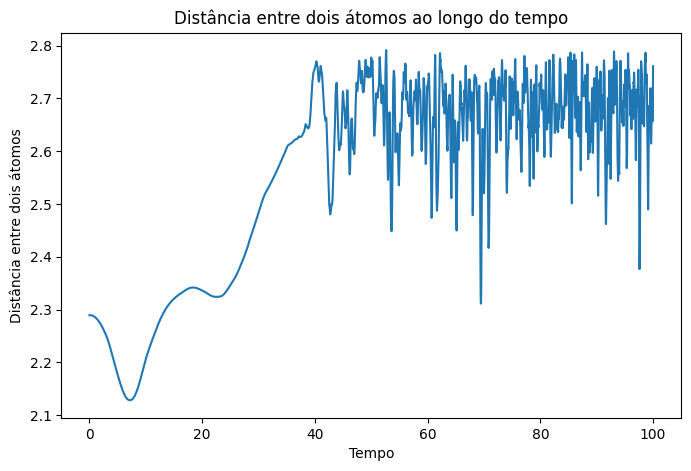

In [21]:
distances = np.array(distances)
time2 = np.linspace(0,100, len(distances))

plt.figure(figsize=(8, 5))
plt.plot(time2, distances)

plt.xlabel('Tempo')
plt.ylabel('Distância entre dois átomos')
plt.title('Distância entre dois átomos ao longo do tempo')
plt.show()

# Problema 3 - Simulação de colisão

In [23]:
from random import random
import numpy as np
import matplotlib.pyplot as plt
from numpy import zeros, copy, sqrt
import sys

* Este primeiro bloco contém as mesmas funções dos problemas anteriores, onde limitamos os atomos na caixa "**def f(r)**" e calculamos as distâncias e forças de interação entre eles "**def calcforces()**", bem como o próprio potencial de interação para cada partícula "**def potential()**".

In [25]:
# Função que calcula a força entre duas partículas. O primeiro 'if' implementa o raio de cut-off. O 'if' dentro do 'else' é útil
# em casos onde na configuração inicial existem átomos muito próximos, e evita que átomos saiam da caixa. Recomendo remover este
# segundo if após ter certeza que a configuração a ser usada é estável.
def f(r):
    if r>rcut:
        return 0.0
    else:
        f = 24.0*eps*( 2.0*(1/r)**(13) -  (1.0/r)**(7))
        if (f<100000):
            return f
        else:
            return 100000.0
            
# Programa que determina a força resultante sobre cada átomo
def calcforces():
    for j in range(N):
        if (j!=i):
            xji = x[j]-x[i]
            if (xji>0.5*L):
                xji = xji - L
            elif (xji <-0.5*L):
                xji = xji + L

            yji = y[j]-y[i]
            if (yji>0.5*L):
                yji = yji - L
            elif (yji <-0.5*L):
                yji = yji + L
            
            rji = sqrt (xji**2 + yji**2)
            fji = f(rji)
            
            coseno = -xji/rji
            seno = -yji/rji
            fx[i]+= fji*coseno
            fy[i]+= fji*seno

def potential():
    Uk__one_part = zeros(N,float)
    Uk_part_value = 0

    for i in range(N):
      for j in range(i+1, N):
          if (j!=i):
              xji = x[j]-x[i]
              if (xji>0.5*L):
                  xji = xji - L
              elif (xji <-0.5*L):
                  xji = xji + L

              yji = y[j]-y[i]
              if (yji>0.5*L):
                  yji = yji - L
              elif (yji <-0.5*L):
                  yji = yji + L
              rji = sqrt (xji**2 + yji**2)
              fji = f(rji)
              coseno = -xji/rji
              seno = -yji/rji
              fx[i]+= fji*coseno
              fy[i]+= fji*seno

              Uk_part_value += 4*eps*((1/rji)**12 - (1/rji)**6)
              Uk__one_part[i] += Uk_part_value

    return Uk_part_value

**Mudanças no bloco abaixo:**
* Modificações nas  posições oniciais das 26 particulas, dentro da funcao "**def init_pos()**";

* Atribuição de velocidades iniciais nulas para o conjunto de partículas no centro, e movimento inicial para a partícula de colisão, em "**def init_vel()**".

In [27]:
# Define as posições iniciais
def init_pos():
    for i in range(N):
        if i<5:
            x[i] = 9 + i
            y[i] = 9
        elif i<10:
            x[i] = 4 + i
            y[i] = 10
        elif i<15:
            x[i] = -1 + i
            y[i] = 11
        elif i<20:
            x[i] = -6 + i
            y[i] = 12
        elif i<25:
            x[i] = -11 + i
            y[i] = 13
        else:
            x[i] = 0
            y[i] = L/2
            
# Define as velocidades iniciais
def init_vel():
    for i in range(N):
        if i == 25:
            vx[i] = 10
            vy[i] = 5
        else:
            vx[i] = 0
            vy[i] = 0

# Inicializa as posições e velocidades anteriores
def init_prev():
    for i in range(N):
         xprev[i] = x[i]-vx[i]*dt
         yprev[i] = y[i]-vy[i]*dt

**Mudanças no bloco abaixo:**
* Neste bloco, apenas mudamos a quantidade de particulas para N = 26, o tamanho da caixa para 20 e excluimos o criterio de Nx*Ny=N;

* As outras funcoes e variaveis permanecem inalteradas.

In [29]:
# Define arquivo de saida
saida = open('MD.xyz.repouso','w')

# Função que escreve a trajetória, que deve ser lida usando o programa VMD
def dump():
    saida.write('{0:d} \n'.format(N))
    saida.write('\n')
    for i in range(N):
        saida.write('1 {0:.3f} {1:.3f} 0.000 \n'.format(x[i], y[i]))
        
######################### Parâmetros da simulação ########################
N = 26

Nx = 5
Ny = 5
v0 = 0

eps = 1.0
rfac = 0.4
L = 20
dt = 0.005
Npassos = 20000
rcut = 3.0
tsave = 0.1
########################### Fim dos parâmetros  ##########################

# if (Nx*Ny != N):
#     print ("O arranjo escolhido de átomos não é consistente com o número total de átomos.")
#     sys.exit()

x = zeros(N,float)
y = zeros(N,float)
vx = zeros(N,float)
vy = zeros(N,float)
xprev = zeros(N,float)
yprev = zeros(N,float)
xnew = zeros(N,float)
ynew = zeros(N, float)
fx = zeros(N,float)
fy = zeros(N,float)

init_pos()
init_vel()
init_prev()

dump()
t = 0
tol1 = 1.0e-6
tol2 = 1.0e-4

Ek_tot = []
Uk_tot = []

Ek_part = zeros(N,float)

while (t < (Npassos*dt)):
    t+=dt
    for i in range(N):
        fx[i] = 0.0
        fy[i] = 0.0
        calcforces()

        xnew[i] = 2.0*x[i] - xprev[i] + fx[i]*dt**2
        
        if xnew[i]<0.0:
            xnew[i]+=L
            x[i]+=L
            xprev[i]+=L
        elif xnew[i] > L:
            xnew[i]-=L
            x[i]-=L
            xprev[i]-=L

        ynew[i] = 2.0*y[i] - yprev[i] + fy[i]*dt**2

        
        if ynew[i]<0.0:
            ynew[i]+=+L
            y[i]+=L
            yprev[i]+=L
        elif ynew[i] > L:
            ynew[i]-=L
            y[i]-=L
            yprev[i]-=L

        vx[i] = (xnew[i]-xprev[i])/(2*dt)
        vy[i] = (ynew[i]-yprev[i])/(2*dt)

        v2 = vx[i]**2 + vy[i]**2
        Ek_part[i] = (1/2)*v2

    Ek_tot.append(sum(Ek_part))
    Uk_tot.append(potential())

    xprev = copy(x)
    yprev = copy(y)
    x = copy(xnew)
    y = copy(ynew)
    #dump()
    if ((t+tol1)%tsave < tol2):
        # print(t)
        dump()

saida.close()

* Neste bloco, não precisamos modificar nada. Podemos ver, pelo plot, o comportamento da energia cinética e potencial de interação. Podemos notar que no começo temos uma alta energia cinética pela velocidade inicial da primeira particula, que posteriormente se dissipa em energia potencial, tendendo à estabilização próxima a energia total.

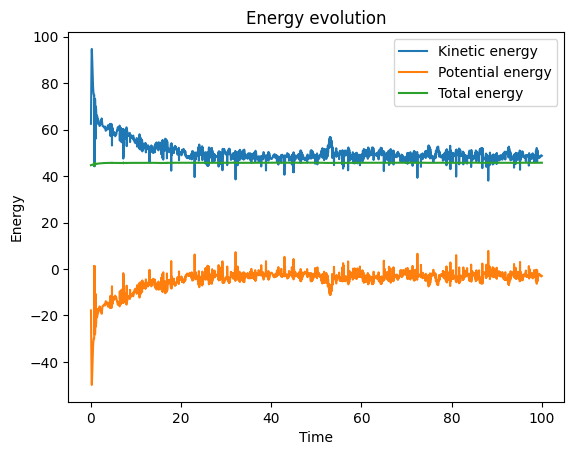

In [31]:
# energias cinetica e potencial em forma de array
Ek_tot = np.array(Ek_tot)
Uk_tot = np.array(Uk_tot)

# criando o array energia total
Etot = zeros(len(Ek_tot),float)

# calculo da energia total
for i in range(len(Etot)):
    Etot[i] = Ek_tot[i] + Uk_tot[i]

# eixo x
time = np.linspace(0, 100, len(Ek_tot))

# plots
plt.plot(time, Ek_tot, label='Kinetic energy')
plt.plot(time, Uk_tot, label='Potential energy')
plt.plot(time, Etot, label='Total energy')

plt.title('Energy evolution')
plt.xlabel('Time')
plt.ylabel('Energy')

plt.legend()
plt.show()